In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
%pwd

In [ ]:
# !pip install detecto

In [2]:
from detecto import core, utils, visualize
from torchvision import transforms
import time
import matplotlib.pyplot as plt

In [ ]:
%ls -l data

In [ ]:
# Convert XML files to CSV format
# utils.xml_to_csv('data/train/training_labels/', 'data/train/train_labels.csv')
# utils.xml_to_csv('data/val/validation_labels/', 'data/val/val_labels.csv')

#### TRAIN IMAGE DATA ACC. CHECK

In [3]:
import pandas as pd

In [4]:
train_labels = pd.read_csv('data/train/train_labels.csv')
train_labels[train_labels['class'] == '.']

,filename,width,height,class,xmin,ymin,xmax,ymax


#### DELETE THE IMAGE IF NEEDED

In [ ]:
# del_image_list = train_labels[train_labels.width == 0].groupby(['filename']).sum()
# del_image_list

In [ ]:
# filename = del_image_list.index.to_numpy()
# filename

In [ ]:
# xml_filename = []
# for file in filename:
#   xml_filename.append(file.replace('.jpg', '.xml'))
# xml_filename

In [ ]:
# location = 'train/training_labels'
# for file in xml_filename:
#   try:
#     path = os.path.join(location, file)
#     os.remove(path)
#     print('%s ahs been removed successfully' %file)
#   except Exception as ex:
#     print(f'No such file : {path}')

In [5]:
# Define custom transforms to apply to dataset
custom_transforms = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ColorJitter(saturation=0.3),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

In [6]:
# Pass in a CSV file instead of XML files for faster Dataset
dataset = core.Dataset('data/train/train_labels.csv', 'data/train/training_images/', transform=custom_transforms)
val_dataset = core.Dataset('data/val/val_labels.csv', 'data/val/val_images/')

In [7]:
# Create own DataLoader with custom options
loader = core.DataLoader(dataset, batch_size=2, shuffle=True)

In [8]:
model = core.Model(['chilli', 'egg', 'pork meat', 'potato', 'pa', 'onion'])

Epoch 1 of 10
Loss: 1.222808479020993
Epoch 2 of 10
Loss: 1.181170913653496
Epoch 3 of 10
Loss: 1.057145412820272
Epoch 4 of 10
Loss: 0.9560857434303333
Epoch 5 of 10
Loss: 0.9355075212720877
Epoch 6 of 10
Loss: 0.9420821085954324
Epoch 7 of 10
Loss: 0.9335716700133605
Epoch 8 of 10
Loss: 0.9377048378093884
Epoch 9 of 10
Loss: 0.9130913940950846
Epoch 10 of 10
Loss: 0.9183466629578899
TIME_TAKES --------------------------------------------------
--- 5435.225628852844 seconds ---
LOSSES --------------------------------------------------


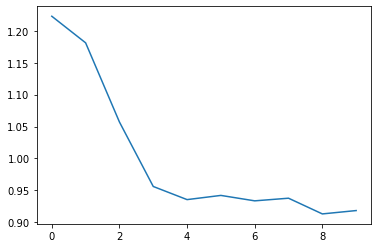

MODEL_WEIGHTS_SAVED
<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [9]:
start_time = time.time()

losses = model.fit(loader, val_dataset, epochs=10, learning_rate=0.01, verbose=True)

print('TIME_TAKES', '-'*50)
print("--- %s seconds ---" % (time.time() - start_time))

print('LOSSES', '-'*50)
plt.plot(losses)
plt.show()

model.save('detection_weights.pth')
print('MODEL_WEIGHTS_SAVED')

torch_model = model.get_internal_model()
print(type(torch_model))

#### IMPORT TEST IMAGE

In [2]:
from skimage import io
image = io.imread('./data/test_image_02.jpg')
print(type(image))

<class 'numpy.ndarray'>


In [16]:
predictions = model.predict(image)
labels, boxes, scores = predictions

In [17]:
pred_labels = labels
pred_labels

['pa', 'egg', 'chilli', 'potato', 'onion', 'pork meat']

In [32]:
import torch
from matplotlib import patches
import matplotlib.pyplot as plt

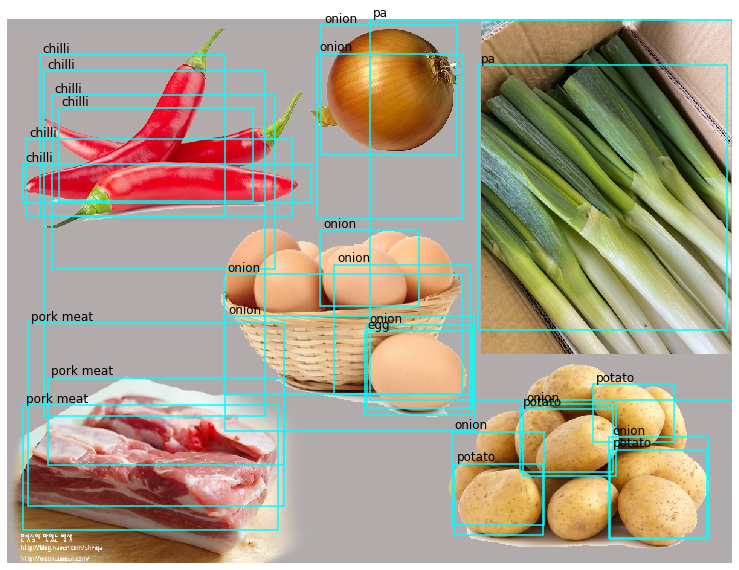

In [43]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_visible(False)
ax.axis('off')

# If the image is already a tensor, convert it back to a PILImage
# and reverse normalize it
if isinstance(image, torch.Tensor):
    image = reverse_normalize(image)
    image = transforms.ToPILImage()(image)
ax.imshow(image)

# Show a single box or multiple if provided
if boxes.ndim == 1:
    boxes = boxes.view(1, 4)

if labels is not None and not utils._is_iterable(labels):
    labels = [labels]

# Plot each box
for i in range(boxes.shape[0]):
    box = boxes[i]
    width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
    initial_pos = (box[0].item(), box[1].item())
    rect = patches.Rectangle(initial_pos, width, height, linewidth=1.5, edgecolor='#00ffff', facecolor='none')
    if labels:
        ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='black')

    ax.add_patch(rect)

plt.show()